In [3]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch

In [4]:
inputs_emb = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)
batch = torch.stack((inputs_emb,inputs_emb))
batch.shape

torch.Size([2, 6, 3])

In [34]:
class CasualAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out=d_out

        # Trainable weights
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries@keys.transpose(1,2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens],-torch.inf )

        # keep in note that attn_weights are actualy non trainable weights. the are just scaling the value matrices. 
        attn_weights  = torch.softmax(attn_scores/keys.shape[0]**0.5, dim=1)
        
        #Apply an additional dropout mask
        # (upper right) to zero out additional attention weights to reduce overfitting during training
        attn_weights=self.dropout(attn_weights)
        
        context_vec = attn_weights@values
        return context_vec, attn_weights, self.W_query


The term "multi-head" refers to dividing the attention mechanism into
multiple "heads," each operating independently. A single
causal attention module can be considered single-head attention, where there
is only `one set of attention weights` processing the input sequentially.
<br>
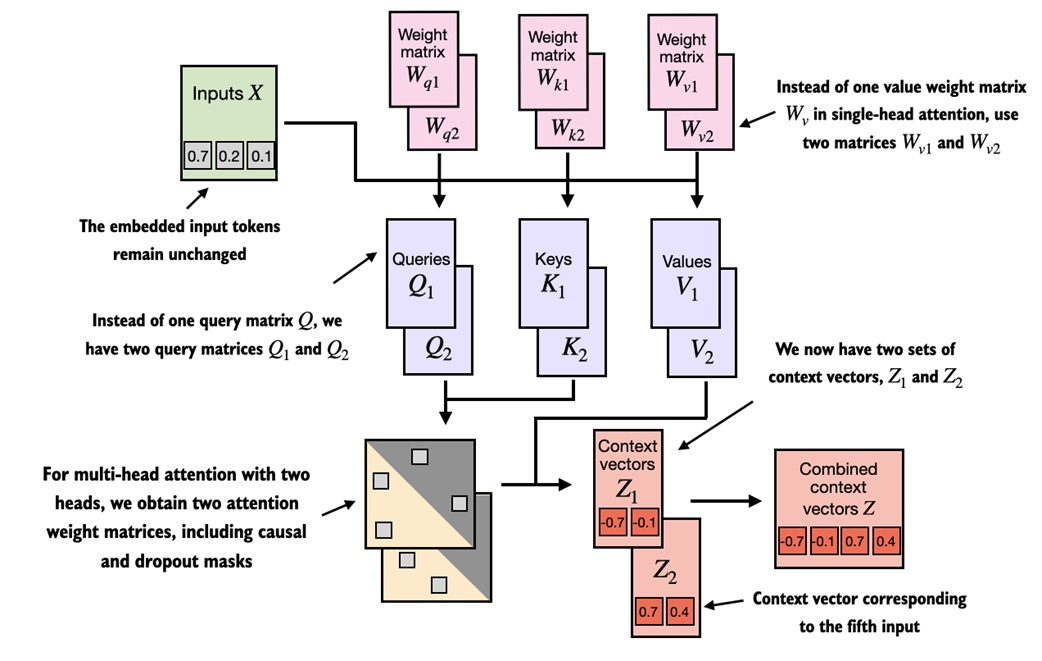
<br> The multi-head attention module in this figure depicts two single-head attention
modules stacked on top of each other. So, instead of using a single matrix Wv
for computing the
value matrices, in a multi-head attention module with two heads, we now have two value weight
matrices: Wv1
and Wv2
. The same applies to the other weight matrices, Wq and Wk. We obtain
two sets of context vectors Z1
and Z2
that we can combine into a single context vector matrix Z.
<br>
Thee main idea behind multi-head attention is to run the
attention mechanism multiple times (in parallel) with different, learned linear
projections -- the results of multiplying the input data (like the query, key,
and value vectors in attention mechanisms) by a weight matrix.

The following MultiHeadAttention class integrates the multi-head
functionality within a single class. It splits the input into multiple heads by
reshaping the projected query, key, and value tensors and then combines the
results from these heads after computing attention.

In [37]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout,num_heads, qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0, 'd_out must be divisible by num_heads'
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads #A
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) #B
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) #C
        queries = self.W_query(x) #C
        values = self.W_value(x) #C
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) #D
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) #D
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)#D
        keys = keys.transpose(1, 2) #E
        queries = queries.transpose(1, 2) #E
        values = values.transpose(1, 2) #E
        attn_scores = queries @ keys.transpose(2, 3) #F
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] #G
        attn_scores.masked_fill_(mask_bool, -torch.inf) #H
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2) #I
        #J
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) #K
        return context_vec


In [41]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


For comparison, the smallest GPT-2 model (117 million parameters) has 12
attention heads and a context vector embedding size of 768. The largest GPT-
2 model (1.5 billion parameters) has 25 attention heads and a context vector
embedding size of 1600. Note that the embedding sizes of the token inputs
and context embeddings are the same in GPT models (d_in = d_out)

In [39]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 768  # GPT-2 context vector embedding size
gpt2_heads=12
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=gpt2_heads)
context_vecs = mha(batch)
# print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 768])
